Following https://medium.com/technovators/machine-learning-based-multi-label-text-classification-9a0e17f88bb4

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')

In [2]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
import umap


In [3]:
train_dict = pickle.load(open('data/train.pkl', 'rb'))
valid_dict = pickle.load(open('data/valid.pkl', 'rb'))
test_dict = pickle.load(open('data/test.pkl', 'rb'))

In [4]:
# Save certain keys only

def load_dict(d:dict):
    
    d_new = {i:{'input': d[i]['input'],
                 'label': d[i]['label'].split(';'),
                 'label_vec': d[i]['label_vec'], 
                 'lemmas': d[i]['lemmas']}
              for i in d
              if len(d[i]['lemmas']) != 0}
    
    return d_new


train_dict = load_dict(train_dict)
valid_dict = load_dict(valid_dict)
test_dict = load_dict(test_dict)

In [5]:
train_data = pd.DataFrame.from_dict(train_dict, orient='index')
valid_data = pd.DataFrame.from_dict(valid_dict, orient='index')
test_data = pd.DataFrame.from_dict(test_dict, orient='index')

In [6]:
vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(train_data["input"])
vectorised_test_documents = vectorizer.transform(test_data["input"])

In [7]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_data['label'])
test_labels = mlb.transform(test_data['label'])


In [53]:
svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
# svmClassifier = CalibratedClassifierCV(svmClassifier)
svmClassifier.fit(vectorised_train_documents, train_labels)

svmPreds = svmClassifier.predict(vectorised_test_documents)
# svmProba = svmClassifier._predict_proba_lr(vectorised_test_documents)

svmDF = svmClassifier.decision_function(vectorised_test_documents)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

In [13]:
accuracy_score(test_labels, svmPreds)

0.881225209343323

In [16]:
f1_score(test_labels, svmPreds, average='micro')

0.9423452492145707

In [17]:
precision_score(test_labels, svmPreds, average='micro')

0.9532726335681154

In [18]:
recall_score(test_labels, svmPreds, average='micro')

0.9316655473472129

In [20]:
# Which categories did the model perform best and worst on? 
confusion_matrix = metrics.multilabel_confusion_matrix(test_labels, svmPreds)

Text(0.5, 1.0, 'Diagnosis')

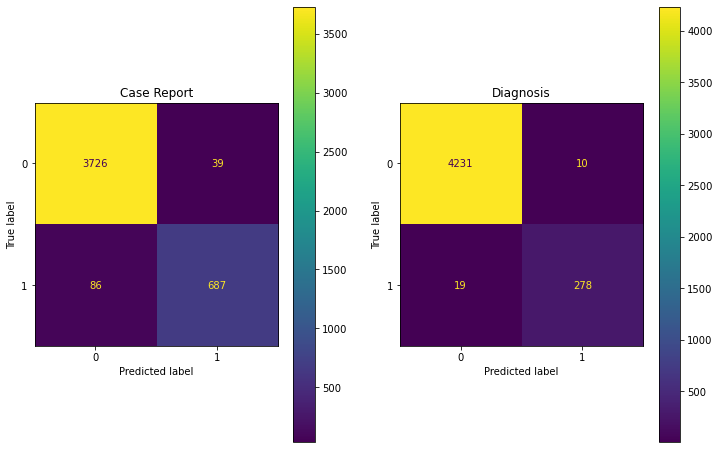

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

disp1 = metrics.ConfusionMatrixDisplay(confusion_matrix[0]).plot(ax=ax1)
disp1.ax_.set_title('Case Report')

disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix[1]).plot(ax=ax2)
disp2.ax_.set_title('Diagnosis')

In [35]:
# with open('map_labels.json', 'r') as f:
#     map_labels = json.load(f)

In [36]:
# map_labels

{'Case Report': 0,
 'Diagnosis': 1,
 'Epidemic Forecasting': 2,
 'General Info': 3,
 'Mechanism': 4,
 'Prevention': 5,
 'Transmission': 6,
 'Treatment': 7,
 '': 8}

In [ ]:
# map_labels_rev = {map_labels[i]:i for i in map_labels}